In [1]:
import numpy as np
import os                                                                                                                                   
import matplotlib.pyplot as plt
plt.style.use(['science','nature','no-latex'])
%matplotlib inline 
import scipy.constants as C

In [120]:
from matplotlib.colors import LogNorm

In [109]:
import pint 
ureg=pint.UnitRegistry()

In [21]:
def outx(i):#position of pixel i at exit
    return (i-85)*15.5/910+2.45 #cm from pixel 86
def inx(i):#position of pixel i at entrance
    return (i-278)*8.8/214+2 #cm from pixel 279
ee,cc,me=C.elementary_charge,C.speed_of_light,C.electron_mass
def E1(i,j):
    y=23
    delta=outx(j)-inx(i)
    B0=-0.8
    r=(y*y+delta*delta)/(2*delta)# centimeter
    R=r/100#meter
    E=np.sqrt(R*R*ee*ee*B0*B0*cc*cc+me**2*cc*4)# IS
    return ((E*ureg.J).to('MeV')).magnitude #MeV
def divergence(i):#rad
    return np.arctan(((i-395)*8.8/214)/75)

dt=1e-4/cc
resolution=1000 #1 meter /1000
Bnew=np.load('Bnew.npy')
def getB(x,y):#meter
    i=int(y*resolution)
    j=int(x*resolution)
    if 0<=i<0.23*resolution and 0<=j<0.198*resolution:
        return np.abs(Bnew[i,j]/10) #from kgauss to T
    else:
        return 0

In [22]:
class hit:
    num=0
    def __init__(self,x, energy, i):
      self.energy = energy
      self.inpixel = i
      self.x = x
      hit.num+=1

    def __lt__(self,other):
      return self.x<other.x
    def __gt__(self,other):
      return self.x>other.x

    @staticmethod
    def count():
      return hit.num
      
class Electron:
    def __init__(self,energy,pixel):
      self.x=inx(pixel)/100
      self.y,self.t=0,0
      self.gamma=energy*1e6*ee/(me*cc*cc)
      self.beta=np.sqrt(1-1/(self.gamma*self.gamma))
      self.ang=divergence(pixel)
      self.v=self.beta*cc
      self.vy= self.v*np.cos(self.ang)
      self.vx= self.v*np.sin(self.ang)
      self.m=self.gamma*me
      self.energy=energy
      self.pixel =pixel

    def show(self):
      print('x:',self.x)
      print('y:',self.y)
      print('vx:',self.vx)
      print('vy:',self.vy)
      print('ang:',self.ang)
      print('gamma',self.gamma)
    
    def onestep(self):
      B=getB(self.x,self.y)
      #r=self.m*self.v/np.abs(ee*B)
      omega=np.abs(ee*B/self.m)
      #sin,cos=self.vx/self.v,self.vy/self.v
      #self.x+=r*(1-np.cos(omega*dt))*sin
      self.x+=self.vx*dt
      self.y+=self.vy*dt
      self.ang+=omega*dt
      self.vx=self.v*np.sin(self.ang)
      self.vy=self.v*np.cos(self.ang)
       
    def run(self):
      #fig,ax=plt.subplots()
      #x0=[]
      #y0=[]
      i=0
      while(i<5000):
        #x0.append(self.x)
        #y0.append(self.y)
        x1,y1=self.x,self.y
        self.onestep()
        if self.y>=0.23 and 0.0245<=self.x<=0.19:
          finalx=x1+(self.x-x1)*(0.23-y1)/(self.y-y1)
          #ax.scatter(x0,y0)
          return hit(finalx,self.energy,self.pixel)
        elif self.x<0:
          #print('hit right')
          return 1
        elif self.x>0.198:
          #print('hit left')
          return 3
        elif self.y<0:
          #print('hit bottom')
          return 4
        elif self.y>0.23:
          #print('run away')
          return 2
        i+=1
      #ax.scatter(x0,y0)
      return 0

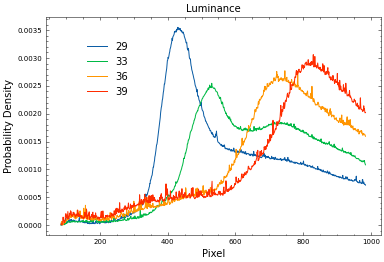

In [100]:
fig,ax=plt.subplots()
y=[]
for i in [29,33,36,39]:
    ss=str(i)
    data=np.load(ss+'.npy')
    data=data[:,400:800]
    x=np.sum(data,axis=1)[85:985]
    x0=x-x.min()
    x1=x0/np.sum(x0)
    ax.plot(np.arange(85,985),x1,label=ss)
    y.append(x1)
ax.set_title('Luminance',fontsize=10)
ax.set_xlabel('Pixel',fontsize=10)
ax.set_ylabel('Probability Density',fontsize=10)
#ax.fill_between(np.arange(85,985),0,np.amin(y,axis=0),color='yellow',alpha=0.5)
fig.legend(loc='center left',bbox_to_anchor=(0.2, 0.7),fontsize=10)
fig.savefig('tonight/gray4.jpg',dpi=600)

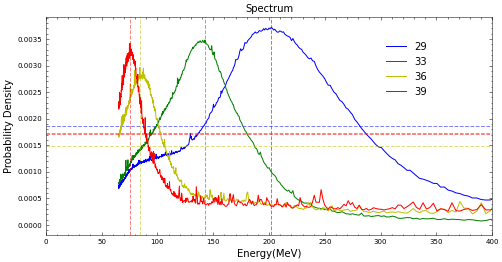

In [209]:
fig,ax=plt.subplots(figsize=(8,4))
y=[]
peaks=[]
colors=['b','g','y','r']
c=0
for i in [29,33,36,39]:
    ss=str(i)
    data=np.load(ss+'.npy')
    data=data[:,400:800]
    x=np.sum(data,axis=1)[243:985]
    x0=x-x.min()
    x1=x0/np.sum(x0)
    e=E1(354,np.arange(243,985))
    ax.plot(e,x1,label=ss,color=colors[c])
    p=E1(354,np.where(x1==np.max(x1))[0][0]+243)
    ax.axvline(p,color=colors[c],ls='--',alpha=0.5)
    ax.axhline(np.max(x1)/2,color=colors[c],ls='--',alpha=0.5)
    peaks.append(p)
    y.append(x1)
    c+=1
# ax.set_xscale('log')
# ax.set_xticks([70,80,100,150,200,300,400,40000])
# ax.set_xticklabels([70,80,100,150,200,300,400,'inf'],fontsize=8)
ax.set_xlim(0,400)
ax.set_title('Spectrum',fontsize=10)
ax.set_xlabel('Energy(MeV)',fontsize=10)
ax.set_ylabel('Probability Density',fontsize=10)
#ax.fill_between(np.arange(85,985),0,np.amin(y,axis=0),color='yellow',alpha=0.5)
fig.legend(loc='center left',bbox_to_anchor=(0.7, 0.7),fontsize=10)
fig.savefig('tonight/energyspec2.jpg',dpi=600)

In [229]:
saved=np.array(y)
e=np.array([E1(354,np.arange(243,985))])
tosave=np.append(e,saved,axis=0)
print(tosave.shape)
np.savetxt('spec.txt',tosave,fmt='%.4e')

(5, 742)


<ipython-input-158-1520436e337d>:14: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pcm=ax[1].pcolormesh(X,Y,data.T)#,norm=LogNorm(1,data.max()))


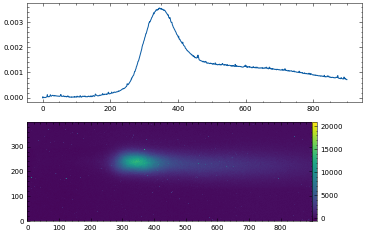

In [158]:
ss='29'
data=np.load(ss+'.npy')
data=data[:,400:800]
x=np.sum(data,axis=1)[85:985]
x0=x-x.min()
x1=x0/np.sum(x0)
fig,ax=plt.subplots(nrows=2)
ax[0].plot(x1)
data=data[85:985]
x=np.arange(900)
e=E1(np.arange(900)+85,354)
y=np.arange(400)
X,Y=np.meshgrid(x,y)
pcm=ax[1].pcolormesh(X,Y,data.T)#,norm=LogNorm(1,data.max()))
cl=fig.colorbar(pcm,ax=ax[1],pad=0)

In [160]:
e.max()

42162.280909680536

In [165]:
inx(354)

5.125233644859813

In [178]:
outx(243)

5.141208791208792

In [175]:
E1(354,245)

12676.861465041473

In [58]:
print(data.max())

22256.0


In [47]:
fig.savefig('123.jpg')

In [87]:
class spectroMeter:
    def __init__(self,fstart=278,fend=492,flength=8.8,foffset=2,bstart=85,bend=985,blength=15.5,boffset=2.45):
      self.fstart = fstart #pixel
      self.fend = fend     #pixel
      self.flength=flength #cm 
      self.foffset=foffset #cm
      self.bstart = bstart
      self.bend = bend
      self.blength=blength
      self.boffset=boffset

    def inx(self,i):
      return ((i-self.fstart)*self.flength/(self.fend-self.fstart)+self.foffset)/100

    def outx(self,i):
      return ((i-self.bstart)*self.blength/(self.bend-self.bstart)+self.boffset)/100

    def divergence(self,i):#rad
      return np.arctan(((i-395)*self.flength/(self.fend-self.fstart))/75)

    def getHits(self,emin,emax,step=1):#in MeV
      hits=[]
      for e in np.arange(emin,emax,step):
          for i in range(354,436):
              tmp=Electron(e,i).run()
              if isinstance(tmp,hit):
                  hits.append(tmp)
      hits.sort()
      name=str(emin)+' '+str(emax)+' '+'hits.npy'
      np.save(name,np.array(hits))
      return name

    def count(self,name,ss):
      ss=str(ss)
      data=np.load(ss+'.npy')
      data=data[:,400:800]
      x=np.sum(data,axis=1)[85:985]
      x0=x-x.min()
      x1=x0/np.sum(x0)

      hits=np.load(name,allow_pickle=True)
      pE=np.zeros(500-71)
      #distribute hits into pixel-bins
      v=[[]]
      vi=0
      i=85
      while(self.outx(i)<hits[0].x):
          i+=1
      flag=i-1 #marks the boundary of  electron hit
      for j in range(0,len(hits)):
          if self.outx(i-1)<hits[j].x<=self.outx(i):
              v[vi].append(hits[j])
          else:
              i+=1
              vi+=1
              v.append([])
      for k in range(self.bend-flag):
          total=0
          for j in range(len(v[k])):
              total+=pfront(v[k][j].inpixel)
          for j in range(len(v[k])):
              et=int(v[k][j].energy)-71
              pE[et]+=x1[flag-self.bstart+k]*pfront(v[k][j].inpixel)/total
      return pE

    def count2(self,name,ss):
      ss=str(ss)
      data=np.load(ss+'.npy')
      data=data[:,400:800]
      x=np.sum(data,axis=1)[85:985]
      x0=x-x.min()
      x1=x0/np.sum(x0)
      
      hits=np.load(name,allow_pickle=True)
      pE=np.zeros((350-71)*5)
      #distribute hits into pixel-bins
      v=[[]]
      vi=0
      i=85
      while(self.outx(i)<hits[0].x):
          i+=1
      flag=i-1 #marks the boundary of  electron hit
      for j in range(0,len(hits)):
          if self.outx(i-1)<hits[j].x<=self.outx(i):
              v[vi].append(hits[j])
          else:
              i+=1
              vi+=1
              v.append([])
      for k in range(self.bend-flag):
          total=0
          for j in range(len(v[k])):
              total+=pfront(v[k][j].inpixel)
          for j in range(len(v[k])):
              et=int((v[k][j].energy-71)*5)
              pE[et]+=x1[flag-self.bstart+k]*pfront(v[k][j].inpixel)/total
      return pE        

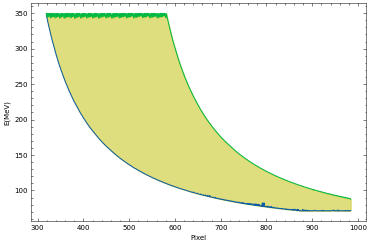

In [106]:
hits=np.load('71 350 hits.npy',allow_pickle=True)
pE=np.zeros((350-71)*5)
lmax=[]
lmin=[]
#distribute hits into pixel-bins
v=[[]]
vi=0
i=85
while(outx(i)/100<hits[0].x):
    i+=1
flag=i-1 #marks the boundary of  electron hit
for j in range(0,len(hits)):
    if outx(i-1)/100<hits[j].x<=outx(i)/100:
        v[vi].append(hits[j])
    else:
        i+=1
        vi+=1
        v.append([])
for k in range(985-flag):
    tmin=v[k][0].energy
    tmax=v[k][0].energy
    for j in range(len(v[k])):
        if(tmin>v[k][j].energy): tmin=v[k][j].energy
        if(tmax<v[k][j].energy): tmax=v[k][j].energy
    lmin.append(tmin)
    lmax.append(tmax)
fig,ax=plt.subplots()
ax.plot(np.arange(flag,985),lmin)
ax.plot(np.arange(flag,985),lmax)
ax.set_xlabel('Pixel')
ax.set_ylabel('E(MeV)')
ax.fill_between(np.arange(flag,985),lmin,lmax,color='y',alpha=0.5)
fig.savefig('hits.jpg',dpi=600)

0.979164619233452
58.971031849970224
0.9829152600758855
81.95661237856025
0.9650019529099261
90.66582903546983
0.9529731647263509
83.89884989628854


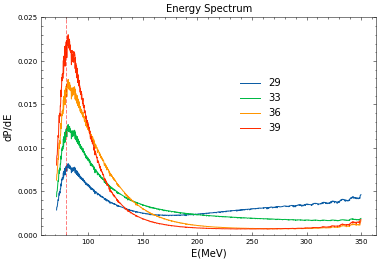

In [101]:
fig,ax=plt.subplots()
for i in [29,33,36,39]:
    ss=str(i)
    S1=spectroMeter()
    pE=S1.count2('71 350 hits.npy',i)
    print(pE.sum())
    E=0
    for i in np.arange(71,200,0.2):
        E+=i*pE[int((i-71)*5)]
    print(E)
    ax.plot(np.arange(71,350,0.2),pE/0.2,label=ss)
    ax.set_xlabel("E(MeV)",fontsize=10)
    ax.set_ylabel("dP/dE",fontsize=10)
    ax.set_ylim(0,0.025)
ax.set_title('Energy Spectrum',fontsize=10)
ax.axvline(80,color='red',ls='--',alpha=0.5)
fig.legend(bbox_to_anchor=(0.7, 0.7),fontsize=10)
fig.savefig('tonight/Energy Spectrum2.jpg',dpi=600)

0.8758074876849888
129.011321797124


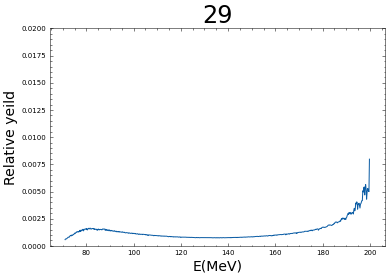

In [82]:
S1=spectroMeter()
pE=S1.count2('71 200 hits.npy')
print(pE.sum())
E=0
for i in np.arange(71,200,0.2):
    E+=i*pE[int((i-71)*5)]
print(E)
fig,ax=plt.subplots()
ax.plot(np.arange(71,200,0.2),pE)
ax.set_xlabel("E(MeV)",fontsize=14)
ax.set_ylabel("Relative yeild",fontsize=14)
ax.set_ylim(0,0.02)
ax.set_title(ss)
fig.savefig(ss+'.png',dpi=600)
np.savetxt('distribution'+ss+'ver2',pE,delimiter=' ')

0.9538475775813784
92.38412617217259


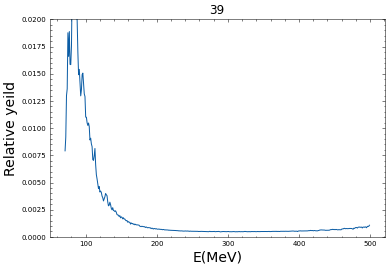

In [15]:

S1=spectroMeter()
pE=S1.count('29hits.npy')
print(pE.sum())
E=0
for i in np.arange(71,300):
    E+=i*pE[i-71]
print(E)
fig,ax=plt.subplots()
ax.plot(np.arange(71,500),pE)
ax.set_xlabel("E(MeV)",fontsize=14)
ax.set_ylabel("Relative yeild",fontsize=14)
ax.set_ylim(0,0.02)
ax.set_title(ss)
fig.savefig(ss+'.png',dpi=600)
np.savetxt('distribution'+ss,pE,delimiter=' ')

In [83]:
S1.getHits(71,350,0.2)

'71 350 hits.npy'

In [6]:
def pfront(i):
    return(y1[i-354])
front=np.load('front.npy') #angular distrbition in front
front1=front[278:492,500:700]
y=np.sum(front1,axis=1)
y0=y-y.min()-20000
y0[y0<0]=0
y0[160:]=0
y1=y0[y0>0]/y0.sum()

In [46]:
print(pE.sum())

0.9157578475650818


In [ ]:
39:92.38412617217259MeV
36:103.50727503830481MeV
33:110.53093057167331MeV
